# Reinforcement Learning

1. RL Intro
2. Dynamic Programing
3. **Tabular Q-Learning**
4. Deep Reinforcement Learning (DQN)

## 3. Tabular Q-Learning

In this notebook we will solve the full reinforcement learning problem by implementing the well-known Q-Learning algorithm. *Full problem* means that the agent will learn from samples instead of using a world model, i.e the agent will learn to solve the task without prior knowledge.

## Theory

In the last notebook we have implemented **Policy Iteration** with **Dynamic Programming** as our first RL algorithm. This was an optimal solution but you will rarely see DP applied to real world problems. Even though those methods are guaranteed to converge with probability 1 to an optimal policy, they suffer from two major drawbacks.

---
### Curse of dimensionality

The first one is the so called **curse of dimensionality**, meaning that the computational requirements often grow exponentially with the number of state variables. Think of our policy array that we just created. It should be clear that this approach does not scale to a very high number of states/actions, which is the case in almost every real world problem. In such situations, even one update swipe through the entire state and action space can be computationally infeasible. Later we will see how to tackles this problem with **function approximation**.

### Planning vs. Learning

The second problem is that we have *cheated* in the last part. More precicely, we have created a **world model** from the knowledge that we had about the grid world. While this was pretty easy in our case, it is very unlikely that you have that much knowledge about a real world environment. Or, that the underlying environment dynamics are given by a very complicated probability distribution that we don't know (or just can't model). In consequence, we can not simply calculate the expectation values for $V(s)$ or $Q(s,a)$. This is not possible since the expectation sum requires the knowledge of the state transition probabilities $\mathcal{P}$ and the reward function $\mathcal{R}$. If we don't have such a model, the next best thing we can do is to simply **learn from trial an error**, e.g. by interacting with the environment and see what happens. If this limitation sounds reasonable to you, welcome to **reinforcement learning**!   

### Value based, model free RL

> In the following, we will solve the **full reinforcement learning problem** by **learning** an **estimate of the value function** from **experience**.

Now instead of *simulating* the outcome of actions through a world model, the agent has to actually **interact** with the environment in order to produce new experience, i.e. gather training data. Although we are **learning** now from this data instead of *planning* ahead, we will stay with the idea of a value function. All RL algorithms that use the concept of a value function are called **value based**. Furthermore, since we assume, and have, no model of the environment, we are in the realm of **model free** reinforcement learning.


> Note that there is also a class of so called **model based** algorithms in the RL literature. However, these algorithms **do not have or assume a perfect world model** either but instead, try to learn the underlying dynamics and transition probabilities. Sometimes, in addtion to a value function and/or policy. The general idea is then to use this **imperfect model** again to *plan ahead* and *simulate* potential outcomes of actions even though the model is not entirely correct.

<img src="./RL_taxonomy.png" alt="Agent-Environment-Loop" style="width: 400px;"/>

---

### Learning from Samples

Recall that within the Policy Iteration framework, we have calculated the **expected return**. We did so by decomposing the return into the immediate reward plus the discounted value of the expected next state or state-action pair. For the action-value function $Q(s,a)$ this has the form (*Bellman Expectation Equation*):

$$\begin{eqnarray} 
Q_{\pi}(s,a) &=& \mathbb{E}\Big[R_{t+1} + \gamma Q_{\pi}(S_{t+1},A_{t+1}) \mid S_t=s, A_t=a\Big] 
\end{eqnarray}$$

Since the calculation of the **expectation** $\mathbb{E}$, requires us to sum over all possible outcomes and hence, requires knowledge about the state transition probabilities $\mathcal{P}$ and the reward function $\mathcal{R}$, we can't do this anymore. Instead, we have to learn from experience produced within the agent-environment loop.

<img src="./RL_pics/AgentEnvLoop.png" alt="Agent-Environment-Loop" style="width: 400px;"/>

By interacting with the environment, an agent will produce *training data* in the form of state transition tuples $(S_t,A_t,R_{t+1},S_{t+1})$. Now instead of calculating the full expectation, we can use those tuples to calculate an **estimate of the true value function** by using them similarly to the Bellman Expectation Equation:

$$\begin{eqnarray} 
Q_{\pi}(s,a) &=& r_{t+1} + \gamma Q_{\pi}(s_{t+1},a_{t+1})
\end{eqnarray}$$

Think of the concrete $(s,a,r,s')$ tuples as distinct *samples*, drawn from the underlying probability distributions $\mathcal{P}$ and $\mathcal{R}$. If we can update $Q$ many times and with a *sufficient number* of distinct samples, our estimate will get closer to the true value function. This is the idea behind the so called **SARSA** algorithm (short for s,a,r,s',a'). However, SARSA does not apply the Bellman Expectation update directly but instead, uses a *softer* update rule. Because all Q-values are only estimates, it is better to not apply the full update $r_{t+1} + \gamma Q(s_{t+1},a_{t+1})$ but rather use it as a **target** towards which we will update the old estimate. The complete idea is thereby to **take the old estimate** $Q(s,a)$ and **update it** only **a little bit towards the difference between old and new estimate**. Formally the update rules is given by:

$$\begin{eqnarray} 
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ \underbrace{r_{t+1} + \gamma Q(s_{t+1}, a_{t+1})}_{target} - \underbrace{Q(s_t, a_t)}_{current} \right] 
\end{eqnarray}$$

where $\alpha$ is a small learning rate $0 < \alpha \leq 1$ and the full expression in square brackets is called the **TD-Error** (TD for Temporal-Difference). Such updates are called **on-policy** because the **same policy** was used to produce the sample and to choose the Q-value which to backup, i.e. to choose $a_{t+1}$ in $s_{t+1}$. Using this update rule, an agent can evaluate a given policy if it visits ~~every~~ enough state-action pairs multiple times. We can then improve the policy like in Policy Iteration and will finally arrive at an optimal policy after enough iterations.

---
### Q-Learning

As it turns out, there exists a very similar update that enables us to **improve the policy directly**. This is known as **Q-Learning**. Compare the new **target** expression to the SARSA target:

$$\begin{eqnarray} 
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ \underbrace{r_{t+1} + \gamma \max_a Q(s_{t+1}, a)}_{target} - \underbrace{Q(s_t, a_t)}_{current} \right] 
\end{eqnarray}$$

This is an **off-policy** update now because $r_{t+1}$ and $s_{t+1}$ are produced by the policy that we are following right now (**behavior policy**), but in the target, we always back up a Q-value according to a second, so called **target policy**, in this case a greedy **max** policy. Using such updates, we could for instance follow a random behavior policy to explore the environment (try out all states and actions) while improve at the same time with the greedy max policy. This is good because when learning from samples, it is crucial to visit *every* (ideally it should be every) state-action pair at least once, but as many times as possible in order to get a decent estimate of the value function. Evaluating such an exploration policy and improving on it at the same time (in one step), makes the update much more efficient compared to the SARSA algorithm.

However, we still need to **improve the behavior policy** over time in order to find an optimal policy. Because we are learning from samples, we first want to make sure that the agent has visited *enough* distinct state-action pairs before improving greedily. Otherwise we may ignore some potentially very good states and actions, only because the agent just has't seen them and therefore, we can't take them into account when improving the policy. On the other hand, we don't want to explore forever. This tradeoff between exploration and exploitation is know as the **exploration-exploitation** dilemma. The most common approach for balancing between these two is the **$\epsilon$-greedy policy**.

---
### E-Greedy Policy

The idea is very simple. In order to explore in the beginning and converge to an optimal policy over time, we will start with a fully random policy and slowly transition to a greedy max policy. This is what the $\epsilon$-greedy policy does. With probability $\epsilon$ select a random action, with probability $1 - \epsilon$ select the best action so far. We can now control the transition by starting with $\epsilon = 1$ and slowly decay it over $n$ time steps until we arrive at an almost fully greedy policy. Formally this can we written as:       

$$\begin{eqnarray}
a = \begin{cases}
        \text{a random action}                             & \text{ with probability } \epsilon\\
        \\
        \arg \displaystyle \max_{a \in \mathcal{A}} Q(s,a) & \text{ with probability } 1-\epsilon
    \end{cases}
\end{eqnarray}$$

*Almost* fully greddy, because we want the policy to be **greedy in the limit with infinite exploration**, which is a property that does provides us some nice convergence guarantees. In practice, this simply means that we will fix $\epsilon$ to some small value $\epsilon_n > 0$ after time step $n$.


---
## Implementation

Now that we have covered the necessary theory, let's start with the implementation of Q-Learning. Like in the last notebook, we will first implement some helper functions to keep the final loop clean and understandable. Also, as in the last notebook, we provide a set of plotting functions for you but this time, adjusted for Q-values. In addition, there is a `plot_agent` function which draws the agents current position on top of the value function or policy. Here is a list of functions that you have to provide in the following. For each, we added relevant comments right before the corresponding code cells.  

###### Provided:
- `plot_value_function`, `plot_policy`, `  plot_agent`, `plot_things`
- `get_current_state`, function that returns the current state of an agent given a raw observation.

###### To be implemented:
- `Q`, Q-Value function
- `choose_egreedy_action`, e-greedy policy
- `update`, Q-learning update for the value function
- basic agent-env loop
- a linear decay schedule for epsilon

Finally combine everything to the Q-Learning algorithm, i.e. implement a Q-Learning agent. :)

---

##### Plotting functions

These are almost the same functions as in the last notebook. Note that `plot_value_function` now takes an **action value function** and **recovers** the **state value function** by summing over all action values in one state. This makes the visualisation more clean. On the downside you can't directly relate those values to the policy anymore. If you want more detailed plotting, e.g. per action value, feel free to modify the code to your needs.

In addition, the policy plot now only takes the action values as argument and will plot a greedy policy from there directly. This is because we don't need to store an explicit policy anymore as you will see below.

In general, use the plotting functions as you please.

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
from IPython import display
sns.set_style("darkgrid")

def plot_value_function(Q, print_values=True):
        
    # recover V from Q by summing over all action values per state
    V = np.sum(Q, axis=2)
    # V = np.max(Q, axis=2)
  
    ax = sns.heatmap(V, vmin=-1.5, vmax=1.5, annot=print_values, 
                        xticklabels=True, yticklabels=True, 
                        square=True, linewidths=.5,  
                        cmap=sns.diverging_palette(10, 220, sep=40, n=256))  
    return ax

def plot_agent(ax, agent_state):
    # agent_state should be a tuple, e.g. (1,1) or (0,1) etc.
    col, row = agent_state[1],agent_state[0]
    ax.add_patch(patches.Rectangle((col, row), 1, 1, zorder=2))
    return ax

def plot_policy(Q, action_set):
    # plot the value funtion as a background
    ax = plot_value_function(Q, print_values=False)
    
    # plot a greedy policies actions in a quiver arrow plot
    num_rows, num_cols, num_actions = Q.shape
    
    for row in range(num_rows):
        for col in range(num_cols):
            state = (row,col)
            actions = np.where(Q[state] == max(Q[state]))[0]
            probability = 1 / len(actions)
            
            for action in actions:
                # Note that action directions and array indices are [row,col] based which corresponds to [y,x] in 
                # cartesian coordinates. Quiver plot works with cartesian coordiantes!
                # Note further that the sns heatmap plot has inverted the y axis which is fine as long as we are
                # adding our arrows to the same axis.
                move_y, move_x = action_set[action]
                length = 2 + 2 * (1 - probability)
                ax.quiver(col+0.5, row+0.5, move_x, move_y, angles='xy', scale_units='xy',zorder=10, scale=length)
             
    return ax

def plot_things(Q, action_set, agent_state=None):

    plt.close()
    fig = plt.figure(figsize=(13,4.5))
    
    # plot value function left
    fig.add_subplot(1,2,1)
    ax1 = plot_value_function(Q)
    if agent_state: plot_agent(ax1, agent_state)

    # plot policy right
    fig.add_subplot(1,2,2)
    ax2 = plot_policy(Q, action_set)
    if agent_state: plot_agent(ax2, agent_state)

For repainted instead of continuous cell output, we use the following snippet **after** your plotting calls.
``` python
plt.pause(0.1) # adjust time to your needs
display.clear_output(wait=True)
```

To activate/deactivate auto-scrolling in output cells, execute the following snippet accordingly in a **separate** code cell. (Can't mix it with python code)
``` javascript
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
```

---

##### Keep track of the agent's current state
In order to update the correct Q-Values later, we need to know where the agent is *right now*, i.e. in which state it is. For that reason, we use the observation and perform a simple lookup of the player character, returning the agent's current state as tuple.

In [2]:
def get_current_state(observation):
    # get the player position from the observations layers, boolean matrix
    player_pos = np.nonzero(observation.layers['P'])
    row = int(player_pos[0])
    col = int(player_pos[1])
    
    # translate the position from world space to state space
    return (row - 1, col - 1)

In [3]:
from gridworlds import exitgames

# Init a new game
game = exitgames.make_game(level=0)
ui   = exitgames.get_notebook_ui()
obs, rew, _ = game.its_showtime()

# Get the agents current state from the observation
state = get_current_state(obs)

# Print and render the state
print("Player position in state space: (%s,%s)" % state)
ui.render(obs)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Player position in state space: (3,0)


---
##### Action-Value function

This function should return a fresh `Q` of size $n \times n \times m$ where $n$ is the number of state rows and cols and $m$ is the number of actions. Initialize it all zeros. The code in the cell below will plot `Q` as a state value function and a greedy policy based on the Q-values. Note that we don't limit the actionset anymore because the agent has no knowlede about *reasonable* actions.

In [4]:
import numpy as np
#action_value_functionfunction should return a fresh Q of size  n×n×m,
#where  n  is the number of state rows and cols and  m  is the number of actions
def action_value_function(num_row, num_cols, num_actions):
    #substract wall tiles
    return np.zeros((num_row-2, num_cols-2, num_actions))

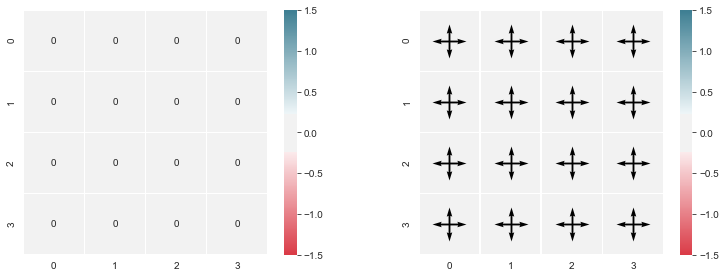

In [5]:
# Testing
Q = action_value_function(game.rows, game.cols, game.action_space)
plot_things(Q, game.get_action_set())

To see how the policy plot renders a greedy policy based on the Q-Values execute the cell bellow. Note that for simplicity, the value function plot sums the values of all actions per state. For that reason, seeing the relationship between the value function and policy plot may not be as straightforward as it was in the last notebook.

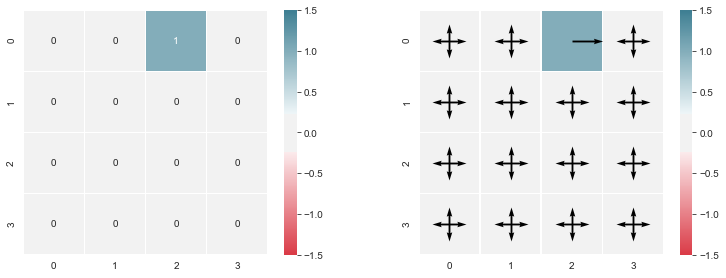

In [6]:
# set action LEFT (3) in state (0,2) to propability 1
Q[(0,2)][3] = 1

plot_things(Q, game.get_action_set())

##### E-Greedy policy

Here we will implement an e-greedy action selection which is basically our e-greedy policy. There is no need to store the policy in a separate array anymore because we can choose the best actions based on the Q-values array directly. We note that the function should take explicit values for epsilon as its third argument. The decay of epsilon will be handeled separately in the loop. Make sure that if there are multiple equally good actions, the greedy part should select randomly between them!


Example:
```python
x = np.array([1,2,3,1])
one_indices = np.where(x==1)[0] 
print(one_indices)
[0 3]
```

Here is what we will implement:

$$\begin{eqnarray}
a = \begin{cases}
        \text{a random action}                             & \text{ with probability } \epsilon\\
        \\
        \arg \displaystyle \max_{a \in \mathcal{A}} Q(s,a) & \text{ with probability } 1-\epsilon
    \end{cases}
\end{eqnarray}$$

In [7]:
import numpy as np
import numpy.random as r

def choose_egreedy_action(Q, state, epsilon):
    # Your code comes here
    randomFloat = np.random.random()
    action = np.random.choice(range(0,5))
    # Return greedy action with probability 1 - epsilon
    if randomFloat >= epsilon:
        # There could be several actions with the same maximum q value, randomly choose one of these
        actions = np.where(Q[state] == max(Q[state]))[0]
        action = np.random.choice(actions)
    return action

In [8]:
#test for epsilon > random number --> random action
print(choose_egreedy_action(Q, (0,2), 1.0))

3


##### Update

Finally we have to implement the update rule. The update should modify a specific Q-value in place and return nothing. Here again is the formula:

$$\begin{eqnarray} 
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ \underbrace{r_{t+1} + \gamma \max_a Q(s_{t+1}, a)}_{target} - \underbrace{Q(s_t, a_t)}_{current} \right] 
\end{eqnarray}$$

In [9]:
def update(Q, state, action, reward, next_state, gamma, alpha):
    target = reward + gamma * np.amax(Q[next_state])
    current = Q[state][action]
    error = target - current
    new_Q_Value = current + alpha * error
    Q[state][action] = new_Q_Value

### Build up from a basic agent-environment loop

Great, now we can start implementing the Q-learning agent. For a clean approach, we build up from a basic agent-environment and add the missing parts one by one. Steps:

1. Reimplement or copy & paste a **basic agent-environment loop**. This loop contains a random agent that can play **multiple episodes** of the game and reports the total reward **per episode**.<br><br>

2. Initialize a fresh **Q-value function** and use it with the **e-greedy action selection** in the loop. Start by using a fixed `epsilon = 1`. We note that we will need the agents current state which we can get from `get_current_state`. The agent is still fully random at this point.<br><br>

3. Implement a **decay schedule** for epsilon. The decay should be controllable with a `final_epsilon` value and a `final_exploration_step` value. After this final step (or if epsilon becomes too small), epsilon should be fixed to this final value. An easy way to verify our implementation is to keep track of epsilon with a list and plot it afterwards. Even though we deacy epsilon now, the agent is still fully random since we don't improve the policy yet.
```
# While in the loop do something like: epsilon_schedule.append(epsilon)
# After the training plot the schedule: plt.plot(epsilon_schedule), plt.show()
```

4. Integrate the **Q-learning update** into the loop. The full Q-learning algorithm is given in a cell below. If you are unsure, use it to check when to do what inside the loop. After this point we have implemented your first (Q-learning) agent that is actually able to **learn** something! Next, we definetly want to gain some insight of what is really going on.<br><br>

5. We wanto to verify what the agent is doing. We have several options ranging from visual feedback to more scientific approaches which you would use in a paper or thesis:
    - **Visual feedback**: e.g. use `ui.render` and `time.sleep`.<br><br>
    - **Live plot of Q and Pi**: e.g. use `plot_things` , `plt.pause` and `display.clear_output(wait=True)`.<br><br>
    - **Data visualisation**: e.g. keep track of `episode_rewards`, `epsilon_schedule` etc. and plot them afterwards.

    Note that the *live* plotting option can be very *slow*. If we run the agent for many episodes this will take some time. For that reason you may prefer to plot the value function and policy only every `n` steps or just after the training. If we still want to plot the Q-learning agent *live* and in action (which is cool to watch) we may prefer to replace the `%matplotlib inline` backend with a more performant backend like `osx, qt, gtk,` etc. For a list of backends execute `%matplotlib -l` on top of a cell. **NOTE: If you change the plotting backend, better restart the notebook.** We do not switch backends from cell to cell. This kind of works but may result in significant slow downs.

The whole algorithm is in the `learnQ` function to facilitate the evaluation later. The function expects all hyperparameters and the ID of the level. It returns Q and data for the visualization of the training.
We already use level 1 in this step.
For performance reasons, the visualization during learning has been completely commented out.

In [28]:
#We implement the algorithm step by step, ensure that point 1. is working, then start with point 2. etc.
from gridworlds import exitgames
import time
import numpy as np
import matplotlib.pyplot as plt

def learnQ(gamma, alpha, epsilon, epsilonDecay, final_epsilon, final_exploration_step, num_episodes, levelId):
    episode_rewards = []
    episode_steps = []
    
    # Create new environment to get its parameters
    game = exitgames.make_game(level=levelId)
    world_map = game.get_world_map()
    num_row = len(world_map)
    num_col = len(world_map[0])
    num_actions = len(game.get_action_set())

    # Initialize new Q
    Q = action_value_function(num_row, num_col, num_actions)
    epsilon_schedule = []
    step = 0

    # Episode loop
    for idx in range(0, num_episodes):
        episode_reward = 0
        episode_step = 0
        # Create new game and start it
        game = exitgames.make_game(level=levelId)
        ui = exitgames.get_notebook_ui()
        observation, reward, _ = game.its_showtime()
        # Play the game until it's finished
        while not game.game_over:
            # get current state
            currentState = get_current_state(observation)
            # get action depending on epsilon
            action = choose_egreedy_action(Q, currentState, epsilon)
            # execute action and get feedback
            observation, reward, _ = game.play(action)
            # Reward is never zero but None. Float is required
            if reward is None:
                reward = 0.0
            # DEACTIVATED DUE TO PERFORMANCE:
            # Render game every step
            # ui.render(observation.board, "COLOR")
            # time.sleep(0.01)
            
            # Get next state (required for update) and update Q
            next_state = get_current_state(observation)
            update(Q, currentState, action, reward, next_state, gamma, alpha)
            # Add reward (required for plotting)
            episode_reward += reward
            
            step += 1
            episode_step += 1
            epsilon_schedule.append(epsilon)
            # Adjust epsilon according to hyper parameters
            if step <= final_exploration_step:
                if epsilon > final_epsilon:
                    epsilon -= epsilonDecay
            else:
                epsilon = final_epsilon
        
        # Required for plotting
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
        # DEACTIVATED DUE TO PERFORMANCE:
        # Live plot of Q and Pi every episode:
        #plot_things(Q, game.get_action_set())
        #plt.pause(0.01)
        #display.clear_output(wait=True)
        
    return (Q, episode_rewards, episode_steps, epsilon_schedule, step)


In [29]:
# Put all your hyperparameters here. We already use level 1 in this step.
gamma = 0.9
alpha = 0.01
epsilon = 1.0
epsilonDecay = 0.000001
final_epsilon = 0.0
final_exploration_step = 50000
num_episodes = 60

levelId = 1

In [30]:
# Learn Q with given parameters for level 1
Q, episode_rewards, episode_steps, epsilon_schedule, step = learnQ(gamma, alpha, epsilon, epsilonDecay, final_epsilon, final_exploration_step, num_episodes, levelId)

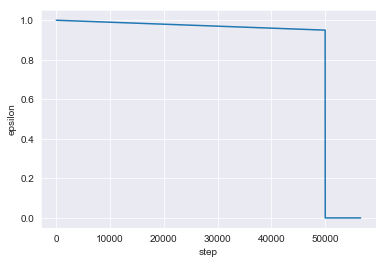

Overall steps: 56608


In [31]:
# Plot Epsilon Schedule
plt.plot(epsilon_schedule) 
plt.ylabel('epsilon')
plt.xlabel('step')
plt.show()
print("Overall steps:", step)

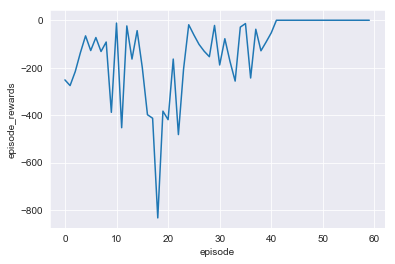

In [32]:
# Plot rewards for each episode
plt.plot(episode_rewards)
plt.ylabel('episode_rewards')
plt.xlabel('episode')
plt.show()

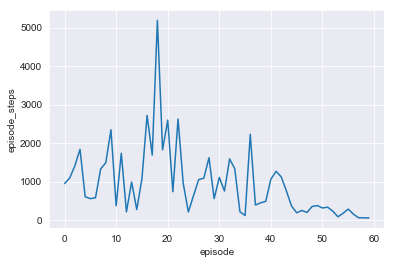

In [33]:
# Plot number of steps per episode
plt.plot(episode_steps)
plt.ylabel('episode_steps')
plt.xlabel('episode')
plt.show()

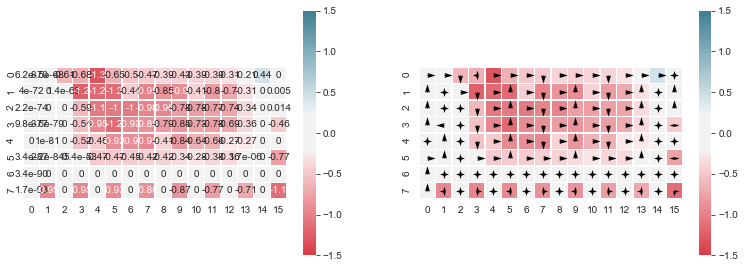

In [34]:
# Plot Q and Pi
plot_things(Q, game.get_action_set())

---
### Q-learning (off-policy TD control) for estimating $\pi \approx \pi∗$

Algorithm parameters: step size $\alpha \in (0, 1]$, small $\epsilon > 0$ <br>
Initialize $Q(s, a)$, for all $s \in S^+$, $a \in A(s)$, arbitrarily except that $Q(terminal , ·) = 0$

Loop for each episode: 
- Initialize $S$ <br>
- Loop for each step of episode: <br>
    - Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)<br>
    - Take action $A$, observe $R, S′$<br>
    - $Q(S, A) \gets Q(S, A) + \alpha \Big[R + γ max_a Q(S′, a) − Q(S, A)\Big]$ 
    - $S \gets S′$
- until $S$ is terminal
---

### Play only loop

The function `play_level` is used to play a level considering Q for a given number of episodes.

In [44]:
# Play loop
from gridworlds import exitgames
import time
import numpy as np
import matplotlib.pyplot as plt

def play_level(num_episodes, levelId, Q):
    for idx in range(0, num_episodes):
        game = exitgames.make_game(level=levelId)
        ui = exitgames.get_notebook_ui()
        observation, _, _ = game.its_showtime()
        while not game.game_over:
            currentState = get_current_state(observation)
            action = choose_egreedy_action(Q, currentState, 0)
            observation, _, _ = game.play(action)
            ui.render(observation.board, "COLOR")
            time.sleep(0.5)

The previously trained Q is used as Q here. The agent avoids all negative rewards until it reaches the goal.
Compared to a random agent, far fewer steps are required, especially at level 1, and no negative reward is generated.

In [46]:
# Play previously created Q for 1 episode
play_level(1, 1, Q)

### Experiment with different hyperparameters (using level 1)

We use `evaluate_q` to play a level considering Q for a given number of episodes. The total reward is counted over all episodes. The agent behaves greedy (epsilon = 0).

In [27]:
# Eval loop
from gridworlds import exitgames
import time
import numpy as np
import matplotlib.pyplot as plt

def evaluate_q(num_episodes, level_id, Q):
    rewards = 0
    for idx in range(0, num_episodes):
        game = exitgames.make_game(level=level_id)
        observation, reward, _ = game.its_showtime()
        while not game.game_over:
            currentState = get_current_state(observation)
            action = choose_egreedy_action(Q, currentState, 0)
            observation, reward, _ = game.play(action)
            if reward is None:
                reward = 0.0
            rewards += reward
    return rewards

For the evaluation, we combine different parameters and consider the reward after a fixed number of episodes.
Several combinations provide perfect results, so in terms of efficiency we evaluate the parameter combination that provides the maximum reward after the smallest number of training episodes as the best.

In [47]:
# Params
gamma = 0.9
alpha = 0.01
epsilon = 1.0
final_epsilon = 0.2

epsilon_decay = [0.001, 0.01]
final_exploration_step = [50000, 60000, 70000]
num_episodes = [1,2,3,4]
num_eval_episodes = 10

levelId = 1

result = []

for episode in num_episodes:
    for final in final_exploration_step:
        for decay in epsilon_decay:
            print("-----------------------")
            print("episodes:", episode)
            print("final exploration step:", final)
            print("epsilon decay:", decay)
            Q, _, _, _, _ = learnQ(gamma, alpha, epsilon, decay, final_epsilon, final, episode, levelId)
            reward = evaluate_q(num_eval_episodes, levelId, Q)
            result.append((reward, episode, final, decay))
            print("reward:", reward)
            # play Q if reward reaches maximum to check the agent.
            # if reward == 10:
            #    play_level(1, 1, Q)
print(result)

-----------------------
episodes: 1
final exploration step: 50000
epsilon decay: 0.001
reward: -5319.0
-----------------------
episodes: 1
final exploration step: 50000
epsilon decay: 0.01
reward: -2767.0
-----------------------
episodes: 1
final exploration step: 60000
epsilon decay: 0.001
reward: -2609.0
-----------------------
episodes: 1
final exploration step: 60000
epsilon decay: 0.01
reward: -3569.0
-----------------------
episodes: 1
final exploration step: 70000
epsilon decay: 0.001
reward: -4182.0
-----------------------
episodes: 1
final exploration step: 70000
epsilon decay: 0.01
reward: -1078.0
-----------------------
episodes: 2
final exploration step: 50000
epsilon decay: 0.001
reward: 10.0
-----------------------
episodes: 2
final exploration step: 50000
epsilon decay: 0.01
reward: 10.0
-----------------------
episodes: 2
final exploration step: 60000
epsilon decay: 0.001
reward: -2184.0
-----------------------
episodes: 2
final exploration step: 60000
epsilon decay: 0.

We obtain a perfect result of 10 (10 episodes in the evaluation with the maximum reward of 1 each) already after **2 training episodes** as well as a **final exploration step** of **50000** and an **epsilon decay** of **0.01**.
The required number of steps is **not** taken into account. After this low number of episodes in training, the agent still needs an extremely large number of steps to reach the goal, it just does not get a negative reward anymore. A configuration with more episodes (as in the previous section) is therefore more sensible in order to reach the goal as quickly as possible.

Suggestion for improvement: A more sensible evaluation in this case therefore results from the consideration of the rewards with simultaneous consideration of the required steps. As soon as the reward is maximized **and** the number of steps is minimized, an optimal parameter combination is achieved.